In [17]:
TRAIN = 0
REBUILD_DATA = 0
AD_TEST_ONLY = 0
KINECT = 0

TRAIN_CSV = 'train_combined_poses.csv'
TEST_CSV = 'test_combined_poses.csv'
AD_TEST_CSV = 'test_additional.csv'

MODEL_ARCH_FILE = 'model_5l_combined_poses_8classes.json'
MODEL_WEIGHTS = 'model_5l_weight_ep50_combined_poses_8classes.hdf5'
TRAINING_HIST = 'training_his_combined_poses_8classes.pickle'

train_data_path = 'train_data_abcde_combined_poses_8classes.npy'
train_label_path = 'train_label_abcde_combined_poses_8classes.npy'
test_data_path = 'test_data_abcde_combined_poses_8classes.npy'
test_label_path = 'test_label_abcde_combined_poses_8classes.npy'
ad_test_data_path = 'test_data_additional_8classes.npy'
ad_test_label_path = 'test_label_additional_8classes.npy'

path = ''
# img_w = 512
# img_w = 424
img_w = 128
img_h = 128
# img_w = 378
# img_h = 161

n_labels = 8

kernel = 3

n_train = 24500
n_test = 10500
n_ad_test = 21500

#     n_train = 2
#     n_test = 2

# SegNet model implemented with keras

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import sys

from skimage.io import imread
from skimage.transform import resize
from skimage import color

from matplotlib import pyplot as plt

import os

from tensorflow.contrib.keras.python.keras import models
from tensorflow.contrib.keras.python.keras.optimizers import SGD, Adam
from tensorflow.contrib.keras.python.keras.models import model_from_json
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping

# Build model
from tensorflow.contrib.keras.python.keras.layers.core import Activation, Reshape, Permute, Flatten, Dense
from tensorflow.contrib.keras.python.keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.contrib.keras.python.keras.layers import Dropout
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization

from tensorflow.contrib.keras.python.keras.utils.vis_utils import plot_model

import json

import pickle

from IPython.display import clear_output

import time

import cv2

# Kinect

In [3]:
from pykinect2 import PyKinectV2
from pykinect2.PyKinectV2 import *
from pykinect2 import PyKinectRuntime

import ctypes
import _ctypes
import pygame

if sys.hexversion >= 0x03000000:
    import _thread as thread
else:
    import thread
    
# colors for drawing different bodies 
SKELETON_COLORS = [pygame.color.THECOLORS["red"],
                    pygame.color.THECOLORS["blue"], 
                    pygame.color.THECOLORS["green"],
                    pygame.color.THECOLORS["orange"], 
                    pygame.color.THECOLORS["purple"], 
                    pygame.color.THECOLORS["yellow"], 
                    pygame.color.THECOLORS["violet"]]

### Utility functions

In [4]:
def label_map(labels):
    label_map = np.zeros([img_h, img_w, n_labels])
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, int(np.ceil(labels[r][c]))] = 1
    return np.uint8(label_map)
#     print(np.unique(label_map))
#     return label_map

In [5]:
def label_map_8_classes(gt2):
    label_map = np.zeros([img_h, img_w, n_labels])
    
#     print(np.unique(gt2))
    for color_chal in [0, 1, 2]:
        x = gt2[:, :, color_chal]
        x[x == 0] = 1
        x[x == 127] = 2
        x[x == 255] = 3
        gt2[:, :, color_chal] = x
        
    gt3 = gt2[:, :, 0] + 10*gt2[:, :, 1] + 100*gt2[:, :, 2]
#     print(np.unique(gt3))
    
#     gt3[gt3 == 77] = 0
    gt3[gt3 == 111] = 0
    gt3[gt3 == 112] = 1
    gt3[gt3 == 121] = 2
    gt3[gt3 == 211] = 3
    gt3[gt3 == 212] = 4
    gt3[gt3 == 221] = 5
    gt3[gt3 == 222] = 6
    gt3[gt3 == 333] = 7
    
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, int(gt3[r][c])] = 1
    
#     111.  112.  121.  211.  212.  221.  222.  333
    
#     print(np.unique(gt3))

    return np.uint8(label_map)
        
#     plt.imshow(gt3, cmap='gray')
#     plt.show()    
    
#     np.savetxt('asd.txt', gt3, fmt='%d')

In [6]:
def prep_data(mode):
#     n_train = 2
#     n_test = 2
    assert mode in {'test', 'train', 'ad_test'}, \
        'mode should be either \'test\' or \'train\' or \'ad_test\''
    data = []
    label = []
    if mode == 'train':
        df = pd.read_csv(path + TRAIN_CSV)
        n = n_train
    elif mode == 'test':
        df = pd.read_csv(path + TEST_CSV)
        n = n_test
    else:
        df = pd.read_csv(path + AD_TEST_CSV)
        n = n_ad_test
        
    for i, item in df.iterrows():
        if i >= n:
            break
        img, gt = [resize(imread(path + item[0]), (img_h, img_w))], resize(imread(path + item[1]), (img_h, img_w), preserve_range=True, order=0)
        
        data.append(img)
        label.append(label_map_8_classes(gt))
        sys.stdout.write('\r')
        sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
                                                    int(100. * (i + 1) / n)))
        sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()
    data, label = np.array(data).swapaxes(1, 3), np.array(label).reshape((n, img_h * img_w, n_labels))
#     print(np.unique(data))
#     print(np.unique(label))

    print(mode + ': OK')
    print('\tshapes: {}, {}'.format(data.shape, label.shape))
    print('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
    print('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

    return data, label


# def prep_data(mode):
# #     n_train = 2
# #     n_test = 2
#     assert mode in {'test', 'train', 'ad_test'}, \
#         'mode should be either \'test\' or \'train\' or \'ad_test\''
#     data = []
#     label = []
#     if mode == 'train':
#         df = pd.read_csv(path + TRAIN_CSV)
#         n = n_train
#     elif mode == 'test':
#         df = pd.read_csv(path + TEST_CSV)
#         n = n_test
#     else:
#         df = pd.read_csv(path + AD_TEST_CSV)
#         n = n_ad_test
        
#     for i, item in df.iterrows():
#         if i >= n:
#             break
#         img, gt = [resize(imread(path + item[0]), (img_h, img_w))], resize(np.clip(~(imread(path + item[1])[:, :, 0]), 0, 1), (img_h, img_w))
        
#         data.append(img)
#         label.append(label_map(gt))
#         sys.stdout.write('\r')
#         sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
#                                                     int(100. * (i + 1) / n)))
#         sys.stdout.flush()
#     sys.stdout.write('\r')
#     sys.stdout.flush()
#     data, label = np.array(data).swapaxes(1, 3), np.array(label).reshape((n, img_h * img_w, n_labels))
# #     print(np.unique(data))
# #     print(np.unique(label))

#     print(mode + ': OK')
#     print('\tshapes: {}, {}'.format(data.shape, label.shape))
#     print('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
#     print('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

#     return data, label

In [25]:
def plot_results_2(output, indx):
    if AD_TEST_ONLY == 0:
        df = pd.read_csv(path + TEST_CSV)
    else:
        df = pd.read_csv(path + AD_TEST_CSV)
    
    n_test_imgs = indx.shape[0]
    plt.figure(figsize=(15, 2 * n_test_imgs))
    
    subplot_indx = 0
    for cur_indx in indx:
        for i, item in df.iterrows():
            if i == cur_indx:
                plt.subplot(n_test_imgs, 5, 3 * subplot_indx + 1)
                plt.title('Input Image')
                plt.axis('off')
                im = resize(imread(path + item[0]), (img_h, img_w))
                plt.imshow(im, cmap='gray')

                plt.subplot(n_test_imgs, 5, 3 * subplot_indx + 2)
                plt.title('Ground Truth')
                plt.axis('off')
                gt = resize(imread(path + item[1]), (img_h, img_w))
                plt.imshow(gt)

                plt.subplot(n_test_imgs, 5, 3 * subplot_indx + 3)
                plt.title('Prediction')
                plt.axis('off')
                labeled = np.argmax(output[subplot_indx], axis=-1)
                plt.imshow(labeled, cmap='gray')

                subplot_indx += 1

                break

#     plt.savefig('result.png')
    plt.show()

In [7]:
# def plot_results_2(output, indx):
#     if AD_TEST_ONLY == 0:
#         df = pd.read_csv(path + TEST_CSV)
#     else:
#         df = pd.read_csv(path + AD_TEST_CSV)
    
#     n_test_imgs = indx.shape[0]
#     plt.figure(figsize=(15, 2 * n_test_imgs))
    
#     subplot_indx = 0
#     for cur_indx in indx:
#         for i, item in df.iterrows():
#             if i == cur_indx:
#                 plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 1)
#                 plt.title('Input Image')
#                 plt.axis('off')
#                 im = resize(imread(path + item[0]), (img_h, img_w))
#                 plt.imshow(im, cmap='gray')

#                 plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 2)
#                 plt.title('Ground Truth')
#                 plt.axis('off')
#                 gt = resize(np.clip(~(imread(path + item[1])[:, :, 0]), 0, 1), (img_h, img_w))
#                 plt.imshow(np.clip(gt, 0, 1), cmap='gray')

#                 plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 3)
#                 plt.title('Prediction')
#                 plt.axis('off')
#                 labeled = np.argmax(output[subplot_indx], axis=-1)
#                 plt.imshow(labeled, cmap='gray')

#                 plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 4)
#                 plt.title('Heat map')
#                 plt.axis('off')
#                 plt.imshow(output[subplot_indx][:, :, 1])

#                 plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 5)
#                 plt.title('Comparison')
#                 plt.axis('off')
#                 rgb = np.empty((img_h, img_w, 3))
#                 rgb[:, :, 0] = labeled
#                 img = resize(imread(path + item[0]), (img_h, img_w))
#                 rgb[:, :, 1] = img
#                 rgb[:, :, 2] = gt
#                 plt.imshow(rgb)

#                 subplot_indx += 1

#                 break

# #     plt.savefig('result.png')
#     plt.show()

### Build Model

In [8]:
# if os.path.isfile(MODEL_ARCH_FILE):
#     print('Loading model...', end='')
#     with open(MODEL_ARCH_FILE, 'r') as f:
#         json_string = f.read()
#     autoencoder = model_from_json(json_string)
#     print('done.')
# else:
print('Defining model...', end='')
encoding_layers = [
    Conv2D(64, (kernel, kernel), padding='same', input_shape=(img_h, img_w, 1)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
]

autoencoder = models.Sequential()
autoencoder.encoding_layers = encoding_layers

for l in autoencoder.encoding_layers:
    autoencoder.add(l)

decoding_layers = [
    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(n_labels, (1, 1), padding='valid'),
    BatchNormalization(),
]
autoencoder.decoding_layers = decoding_layers
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

autoencoder.add(Reshape((n_labels, img_h * img_w)))
autoencoder.add(Permute((2, 1)))
autoencoder.add(Activation('softmax'))

with open(MODEL_ARCH_FILE, 'w') as outfile:
    outfile.write(json.dumps(json.loads(autoencoder.to_json()), indent=2))

print('done.')

print('Compiling model...', end='')
# optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
optimizer = Adam(lr=0.001, decay=0.0005)
autoencoder.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
print('done.')

print(autoencoder.summary())

Defining model...done.
Compiling model...done.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 

### Data

In [9]:
if 'train_data' in globals():
    del train_data
if 'train_label' in globals():
    del train_label
if 'test_data' in globals():
    del test_data
if 'test_label' in globals():
    del test_label

if 'data' in locals():
    del data
if 'label' in locals():
    del label

In [10]:
n_train = 24500
n_test = 10500
n_ad_test = 21500

# n_train = 2
# n_test = 2

if AD_TEST_ONLY == 0:
    if KINECT == 0:
        if os.path.isfile(train_data_path) and os.path.isfile(train_label_path) and REBUILD_DATA == 0:
            print('Loading training data...', end='')
            train_data = np.load(train_data_path)
            train_label = np.load(train_label_path)
            print('done.')
        else:
            train_data, train_label = prep_data('train')
            np.save(train_data_path, train_data)
            np.save(train_label_path, train_label)

    if os.path.isfile(test_data_path) and os.path.isfile(test_label_path) and REBUILD_DATA == 0:
        print('Loading testing data...', end='')
        test_data = np.load(test_data_path)
        test_label = np.load(test_label_path)
        print('done.')
    else:
        test_data, test_label = prep_data('test')
        np.save(test_data_path, test_data)
        np.save(test_label_path, test_label)
else:
    if os.path.isfile(ad_test_data_path) and os.path.isfile(ad_test_label_path):
        print('Loading additional testing data...', end='')
        test_data = np.load(ad_test_data_path)
        test_label = np.load(ad_test_label_path)
        print('done.')
    else:
        test_data, test_label = prep_data('ad_test')
        np.save(ad_test_data_path, test_data)
        np.save(ad_test_label_path, test_label)

train: OK==================>] 100%
	shapes: (24500, 128, 128, 1), (24500, 16384, 8)
	types:  float64, uint8
	memory: 3062.5, 3062.5 MB
test: OK==================>] 100%
	shapes: (10500, 128, 128, 1), (10500, 16384, 8)
	types:  float64, uint8
	memory: 1312.5, 1312.5 MB


In [12]:
# for c_indx in [0, 1, 2, 3, 4, 5, 6, 7]:
#     print(np.unique(train_label[:, :, c_indx]))
#     print(np.unique(train_label[:, :, c_indx]))

### Train model or load existing weights

In [13]:
if TRAIN == 1 and AD_TEST_ONLY == 0 and KINECT == 0:
    start_time = time.time()
    
    nb_epoch = 20
    batch_size = 8

    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

    history = autoencoder.fit(train_data, train_label,
                              batch_size=batch_size, epochs=nb_epoch,
                              verbose=1,
                              validation_data=(test_data, test_label),
                              callbacks=[early_stopping])
    
    training_time = time.time() - start_time
    print('> Training time on GTX1080: ' + str(training_time) + ' sec')

    # Save trained model
    autoencoder.save_weights(MODEL_WEIGHTS)
    
    # Save training history
    with open(TRAINING_HIST, 'wb') as f:
        pickle.dump(history.history, f)
        
    history_ = history.history
else:
    print('Loading trained weights...', end='')
    # Load trained model
    autoencoder.load_weights(MODEL_WEIGHTS)
    
    # Load training history
    file = open(TRAINING_HIST, 'rb')
    history_ = pickle.load(file)
    print('done.')

Train on 24500 samples, validate on 10500 samples
Epoch 1/20
24500/24500 [==============================] - 789s - loss: 0.2377 - acc: 0.9381 - val_loss: 0.1477 - val_acc: 0.9527
Epoch 2/20
24500/24500 [==============================] - 760s - loss: 0.1198 - acc: 0.9592 - val_loss: 0.1044 - val_acc: 0.9629
Epoch 3/20
24500/24500 [==============================] - 754s - loss: 0.0922 - acc: 0.9665 - val_loss: 0.0812 - val_acc: 0.9702
Epoch 4/20
24500/24500 [==============================] - 753s - loss: 0.0774 - acc: 0.9713 - val_loss: 0.0717 - val_acc: 0.9732
Epoch 5/20
24500/24500 [==============================] - 754s - loss: 0.0681 - acc: 0.9744 - val_loss: 0.0637 - val_acc: 0.9761
Epoch 6/20
24500/24500 [==============================] - 754s - loss: 0.0618 - acc: 0.9767 - val_loss: 0.0598 - val_acc: 0.9774
Epoch 7/20
24500/24500 [==============================] - 754s - loss: 0.0573 - acc: 0.9784 - val_loss: 0.0545 - val_acc: 0.9795
Epoch 8/20
24500/24500 [=======================

In [ ]:
# Train on 24500 samples, validate on 10500 samples
# Epoch 1/20
# 24500/24500 [==============================] - 789s - loss: 0.2377 - acc: 0.9381 - val_loss: 0.1477 - val_acc: 0.9527
# Epoch 2/20
# 24500/24500 [==============================] - 760s - loss: 0.1198 - acc: 0.9592 - val_loss: 0.1044 - val_acc: 0.9629
# Epoch 3/20
# 24500/24500 [==============================] - 754s - loss: 0.0922 - acc: 0.9665 - val_loss: 0.0812 - val_acc: 0.9702
# Epoch 4/20
# 24500/24500 [==============================] - 753s - loss: 0.0774 - acc: 0.9713 - val_loss: 0.0717 - val_acc: 0.9732
# Epoch 5/20
# 24500/24500 [==============================] - 754s - loss: 0.0681 - acc: 0.9744 - val_loss: 0.0637 - val_acc: 0.9761
# Epoch 6/20
# 24500/24500 [==============================] - 754s - loss: 0.0618 - acc: 0.9767 - val_loss: 0.0598 - val_acc: 0.9774
# Epoch 7/20
# 24500/24500 [==============================] - 754s - loss: 0.0573 - acc: 0.9784 - val_loss: 0.0545 - val_acc: 0.9795
# Epoch 8/20
# 24500/24500 [==============================] - 754s - loss: 0.0536 - acc: 0.9797 - val_loss: 0.0519 - val_acc: 0.9805
# Epoch 9/20
# 24500/24500 [==============================] - 754s - loss: 0.0507 - acc: 0.9808 - val_loss: 0.0495 - val_acc: 0.9814
# Epoch 10/20
# 24500/24500 [==============================] - 755s - loss: 0.0484 - acc: 0.9817 - val_loss: 0.0489 - val_acc: 0.9816
# Epoch 11/20
# 24500/24500 [==============================] - 758s - loss: 0.0464 - acc: 0.9825 - val_loss: 0.0458 - val_acc: 0.9829
# Epoch 12/20
# 24500/24500 [==============================] - 755s - loss: 0.0447 - acc: 0.9831 - val_loss: 0.0450 - val_acc: 0.9831
# Epoch 13/20
# 24500/24500 [==============================] - 761s - loss: 0.0432 - acc: 0.9837 - val_loss: 0.0425 - val_acc: 0.9842
# Epoch 14/20
# 24500/24500 [==============================] - 754s - loss: 0.0420 - acc: 0.9842 - val_loss: 0.0424 - val_acc: 0.9842
# Epoch 15/20
# 24500/24500 [==============================] - 753s - loss: 0.0409 - acc: 0.9846 - val_loss: 0.0414 - val_acc: 0.9845
# Epoch 16/20
# 24500/24500 [==============================] - 754s - loss: 0.0399 - acc: 0.9850 - val_loss: 0.0403 - val_acc: 0.9850
# Epoch 17/20
# 24500/24500 [==============================] - 755s - loss: 0.0389 - acc: 0.9853 - val_loss: 0.0393 - val_acc: 0.9854
# Epoch 18/20
# 24500/24500 [==============================] - 754s - loss: 0.0381 - acc: 0.9856 - val_loss: 0.0390 - val_acc: 0.9855
# Epoch 19/20
# 24500/24500 [==============================] - 754s - loss: 0.0374 - acc: 0.9859 - val_loss: 0.0387 - val_acc: 0.9856
# Epoch 20/20
# 24500/24500 [==============================] - 776s - loss: 0.0368 - acc: 0.9862 - val_loss: 0.0382 - val_acc: 0.9858
# > Training time on GTX1080: 15184.509108304977 sec

# Training summary

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


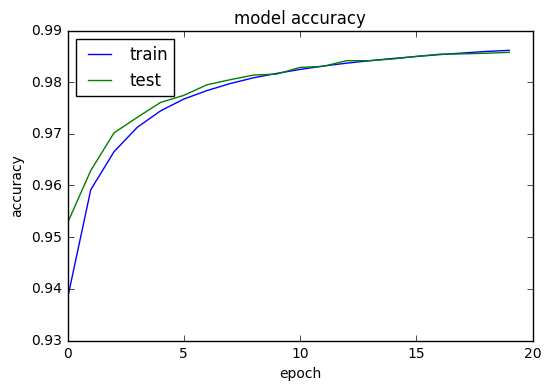

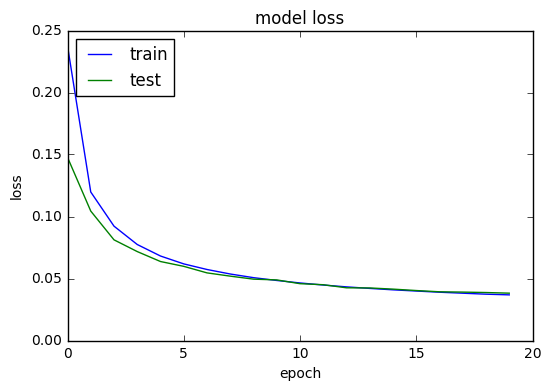

In [18]:
if KINECT == 0:
    # list all data in history
    print(history_.keys())
    # summarize history for accuracy
    plt.plot(history_['acc'])
    plt.plot(history_['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history_['loss'])
    plt.plot(history_['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Model visualization

In [14]:
# plot_model(autoencoder, to_file='model.png', show_shapes=True)

### Load testing data and evaluate score

In [15]:
# if KINECT == 0:
score = autoencoder.evaluate(test_data, test_label, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# score = autoencoder.evaluate(train_data, train_label, verbose=0)
# print('Train score:', score[0])
# print('Train accuracy:', score[1])

10496/10500 [============================>.] - ETA: 0sTest score: 0.0381674893697
Test accuracy: 0.985772234235


### Visualizing results

In [19]:
# if KINECT == 0:
testing_indx = np.random.choice(n_test, 5)

In [134]:
def get_rgb_from_class(pred_cls):
    if pred_cls == 0:
        return [0, 0, 0]
    elif pred_cls == 1:
        return [0, 0, 127]
    elif pred_cls == 2:
        return [0, 127, 0]
    elif pred_cls == 3:
        return [127, 0, 0]
    elif pred_cls == 4:
        return [127, 0, 127]
    elif pred_cls == 5:
        return [127, 127, 0]
    elif pred_cls == 6:
        return [127, 127, 127]
    elif pred_cls == 7:
        return [255, 255, 255]
    
def plot_results_2(output, indx):
    if AD_TEST_ONLY == 0:
        df = pd.read_csv(path + TEST_CSV)
    else:
        df = pd.read_csv(path + AD_TEST_CSV)
    
    n_test_imgs = indx.shape[0]
    plt.figure(figsize=(7, 2 * n_test_imgs))
    
    subplot_indx = 0
    for cur_indx in indx:
        for i, item in df.iterrows():
            if i == cur_indx:
                plt.subplot(n_test_imgs, 3, 3 * subplot_indx + 1)
                plt.title('Input Image')
                plt.axis('off')
                im = resize(imread(path + item[0]), (img_h, img_w))
                plt.imshow(im, cmap='gray')

                plt.subplot(n_test_imgs, 3, 3 * subplot_indx + 2)
                plt.title('Ground Truth')
                plt.axis('off')
                gt = resize(imread(path + item[1]), (img_h, img_w))
                plt.imshow(gt)

                plt.subplot(n_test_imgs, 3, 3 * subplot_indx + 3)
                plt.title('Prediction')
                plt.axis('off')
                
                labeled = np.ones([img_h, img_w, 3]) * 255
                output = np.reshape(output, (5, 128, 128))
                
                for r in range(img_h):
                    for c in range(img_w):
                        re, gr, bl = get_rgb_from_class(output[subplot_indx, r, c])
                        labeled[r, c, 2] = re
                        labeled[r, c, 1] = gr
                        labeled[r, c, 0] = bl
                
                labeled = np.uint8(labeled)
                plt.imshow(labeled)

                subplot_indx += 1

                break

#     plt.savefig('result.png')
    plt.show()

5/5 [==============================] - 0s


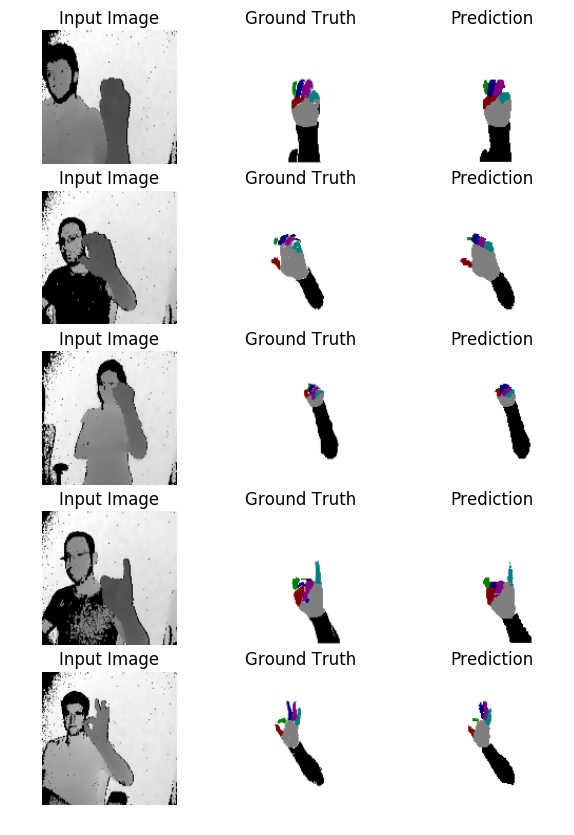

In [135]:
test_ite = test_data[testing_indx, :, :, :]
# test_ite = np.expand_dims(test_ite, axis=0)

# output = autoencoder.predict_proba(test_ite, verbose=1)
output = autoencoder.predict_classes(test_ite, verbose=1)

plot_results_2(output, testing_indx)

In [ ]:
test_ite_ = test_ite[0, :, :, 0]
# test_ite_ = np.rot90(test_ite_, -1)

# cv2.imshow('depth', test_ite_)

frame8bit = test_ite_
# frame8bit = np.flip(frame8bit, 0)
# frame8bit = np.rot90(frame8bit, -1)
print(frame8bit)

cv2.imshow('original image', frame8bit)
print(frame8bit.shape)

frame8bit_for_autoencoder = np.resize(frame8bit, (1, 128, 128, 1))

output = autoencoder.predict_proba(frame8bit_for_autoencoder, verbose=0)
output = output.reshape((output.shape[0], img_h, img_w, n_labels))

frame8bit = resize(frame8bit[:, :], (img_h, img_w))

rgb = np.zeros((img_h, 2*img_w, 3))
labeled = np.argmax(output[0], axis=-1)

rgb[:, :img_w, 0] = frame8bit
rgb[:, :img_w, 1] = frame8bit
rgb[:, :img_w, 2] = frame8bit

rgb[:, img_w:, 0] = labeled

#             rgb = cv2.resize(rgb, (2*256, 213))
# #             rgb = cv2.resize(rgb, (512, 424))

pred_time = time.time() - start_time
print('FPS: ' + str(int(1.0/pred_time)))

cv2.imshow('hand segmentation', rgb)


k = cv2.waitKey(0) & 0xff
if k == 27:     # Esc
    cv2.destroyAllWindows()

In [ ]:
cv2.destroyAllWindows()

# Realtime visualization

In [ ]:
if KINECT == 0:
    # test_data, test_label = prep_data('test')

    if AD_TEST_ONLY == 0:
        df = pd.read_csv(path + TEST_CSV)
    else:
        df = pd.read_csv(path + AD_TEST_CSV)

    n_test_imgs = 1
    n_type_outputs = 3

    for i, item in df.iterrows():
        clear_output(wait=True)

        # Call trained model
        test_ite = test_data[i, :, :, :]
        test_ite = np.expand_dims(test_ite, axis=0)
        print(test_ite.shape)
        start_time = time.time()
        output = autoencoder.predict_proba(test_ite, verbose=0)
        pred_time = time.time() - start_time
        output = output.reshape((output.shape[0], img_h, img_w, n_labels))

        # Load input image
        im = resize(imread(path + item[0]), (img_h, img_w))

        # Load ground truth
        gt = np.ceil(resize(~(imread(path + item[1])[:, :, 0]), (img_h, img_w))).astype(int)

    #     rgb = np.empty((img_h, img_w, 3))
        rgb = np.empty((img_h, 3*img_w, 3))
        labeled = np.argmax(output[0], axis=-1)
        img = resize(imread(path + item[0]), (img_h, img_w))
        rgb[:, :img_w, 0] = img
        rgb[:, :img_w, 1] = img
        rgb[:, :img_w, 2] = img

        rgb[:, img_w:2*img_w, 0] = img
        rgb[:, img_w:2*img_w, 1] = img
        rgb[:, img_w:2*img_w, 2] = img + gt

        rgb[:, 2*img_w:, 0] = img
        rgb[:, 2*img_w:, 1] = img + labeled
        rgb[:, 2*img_w:, 2] = img

        rgb = cv2.resize(rgb, (3*256, 213))

        cv2.imshow('hand segmentation', rgb)
        print('FPS: ' + str(int(1.0/pred_time)))

        k = cv2.waitKey(30) & 0xff
        if k == 27:     # Esc
            cv2.destroyAllWindows()
            break

# Kinect Hand Segmentation

In [ ]:
cv2.destroyAllWindows()
kinect.close()

In [ ]:
if KINECT == 1:
    kinect = PyKinectRuntime.PyKinectRuntime(PyKinectV2.FrameSourceTypes_Depth)
    
    for dir_path, dir_names, file_names in os.walk('E:/fingerpaint_dataset_segnet/data/depth/combinedSubjectA_depth'):
        for file_name in [f for f in file_names if f.endswith('.png')]:
            depth_img = os.path.join(dir_path, file_name).replace("\\","/")
            
#     while True:
#         if kinect.has_new_depth_frame():
            clear_output(wait=True)
            
            start_time = time.time()
            
            # Getting frames
            frame = kinect.get_last_color_frame()
#             frame = kinect.get_last_depth_frame()

            # Displaying frames
            # if frame is None:  # some usb hub do not provide the depth image. it works with Kinect studio though
            #     return
            
#             print(frame)
            f8=np.uint8(frame.clip(1,1000)/16.)
#             f8=np.uint8(frame.clip(1,4000)/16.)
#             frame8bit_ = frame8bit
#             frame8bit = np.dstack((frame8bit_, frame8bit_, frame8bit_))
            frame8bit = np.dstack((f8,f8,f8))
            frame8bit = np.reshape(frame8bit, (kinect.depth_frame_desc.Height, kinect.depth_frame_desc.Width, 3))
            frame8bit = frame8bit[:, :, 0]
            
            frame8bit = imread(depth_img)
            
            frame8bit = resize(frame8bit, (img_h, img_w))
            
            frame8bit_for_autoencoder = np.rot90(frame8bit)
            frame8bit_for_autoencoder = np.flip(frame8bit_for_autoencoder, 0)
            
            frame8bit_for_autoencoder = np.resize(frame8bit_for_autoencoder, (1, 128, 128, 1))
            
            output = autoencoder.predict_proba(frame8bit_for_autoencoder, verbose=0)
            output = output.reshape((output.shape[0], img_h, img_w, n_labels))

            rgb = np.zeros((img_h, 2*img_w, 3))
            labeled = np.argmax(output[0], axis=-1)
            
            rgb[:, :img_w, 0] = frame8bit
            rgb[:, :img_w, 1] = frame8bit
            rgb[:, :img_w, 2] = frame8bit
            
            rgb[:, img_w:, 0] = frame8bit
            rgb[:, img_w:, 1] = frame8bit + labeled
            rgb[:, img_w:, 2] = frame8bit

            rgb = cv2.resize(rgb, (2*256, 213))
# #             rgb = cv2.resize(rgb, (512, 424))
            
            pred_time = time.time() - start_time
            print('FPS: ' + str(int(1.0/pred_time)))
            
            cv2.imshow('hand segmentation', rgb)

            k = cv2.waitKey(30) & 0xff
            if k == 27:     # Esc
                # Releasing frames
                frame = None
                cv2.destroyAllWindows()
                kinect.close()
                break